In [1]:
import pandas as pd
import sqlite3
from matplotlib import ticker, pyplot as plt
from itertools import combinations
from collections import Counter

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [8]:
conn = sqlite3.connect("../db.sqlite3")

query = """
    SELECT
        restaurant_order.id AS order_id,
        restaurant_order.datetime AS order_datetime,
        restaurant_orderitem.quantity,
        restaurant_product.id AS product_id,
        restaurant_product.name AS product_name,
        restaurant_product.price AS product_price
    FROM main.restaurant_order
    JOIN main.restaurant_orderitem ON main.restaurant_order.id = main.restaurant_orderitem.order_id
    JOIN main.restaurant_product ON main.restaurant_orderitem.product_id = main.restaurant_product.id
"""

results = conn.execute(query).fetchall()

df = pd.DataFrame(results, columns=["order_id", "datetime", "quantity", "product_id", "product_name", "price"])

df.to_csv("../restaurant_data.csv", index=False)

conn.close()
display(df)


,order_id,datetime,quantity,product_id,product_name,price
0,1,2019-08-03 20:25:00,2,6,Plain Papadum,0.80
1,1,2019-08-03 20:25:00,1,240,King Prawn Balti,12.95
2,1,2019-08-03 20:25:00,1,19,Garlic Naan,2.95
3,1,2019-08-03 20:25:00,1,36,Mushroom Rice,3.95
4,1,2019-08-03 20:25:00,1,111,Paneer Tikka Masala,8.95
...,...,...,...,...,...,...
74813,3255,2016-05-18 18:53:00,2,247,House Red wine 75cl,17.95
74814,12905,2016-05-14 19:28:00,2,247,House Red wine 75cl,17.95
74815,3272,2016-05-10 13:18:00,2,247,House Red wine 75cl,17.95
74816,11404,2016-04-07 19:04:00,1,248,House white wine 75cl,17.95


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

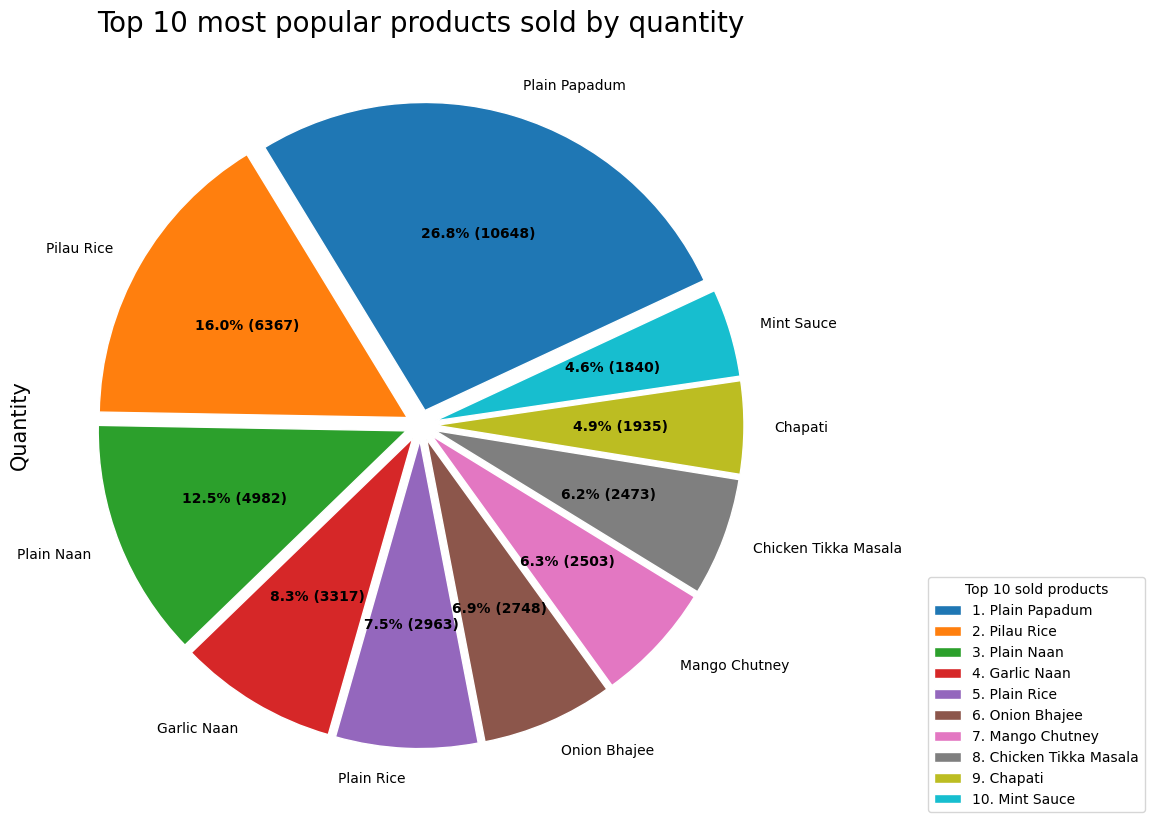

In [3]:
product_sales = df.groupby(["product_name"]).agg({"quantity": "sum"})
top_products = product_sales.sort_values("quantity", ascending=False).head(10)
top_products["percentage"] = top_products["quantity"] / top_products["quantity"].sum() * 100

explode = [0.05] * 10
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    top_products["quantity"],
    labels=top_products.index,
    autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*top_products['quantity'].sum())})",
    startangle=25,
    explode=explode,
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
)
plt.setp(autotexts, size = 10, weight ="bold")
ax.set_title("Top 10 most popular products sold by quantity").set_size(20)
labels = [f"{idx+1}. {name}" for idx, name in enumerate(top_products.index)]
ax.legend(
    wedges,
    labels,
    title="Top 10 sold products",
    loc="center left",
    bbox_to_anchor=(1.15, -0.1, 0.5, 0.5)
)
ax.set_ylabel("Quantity").set_size(15)
plt.show()


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

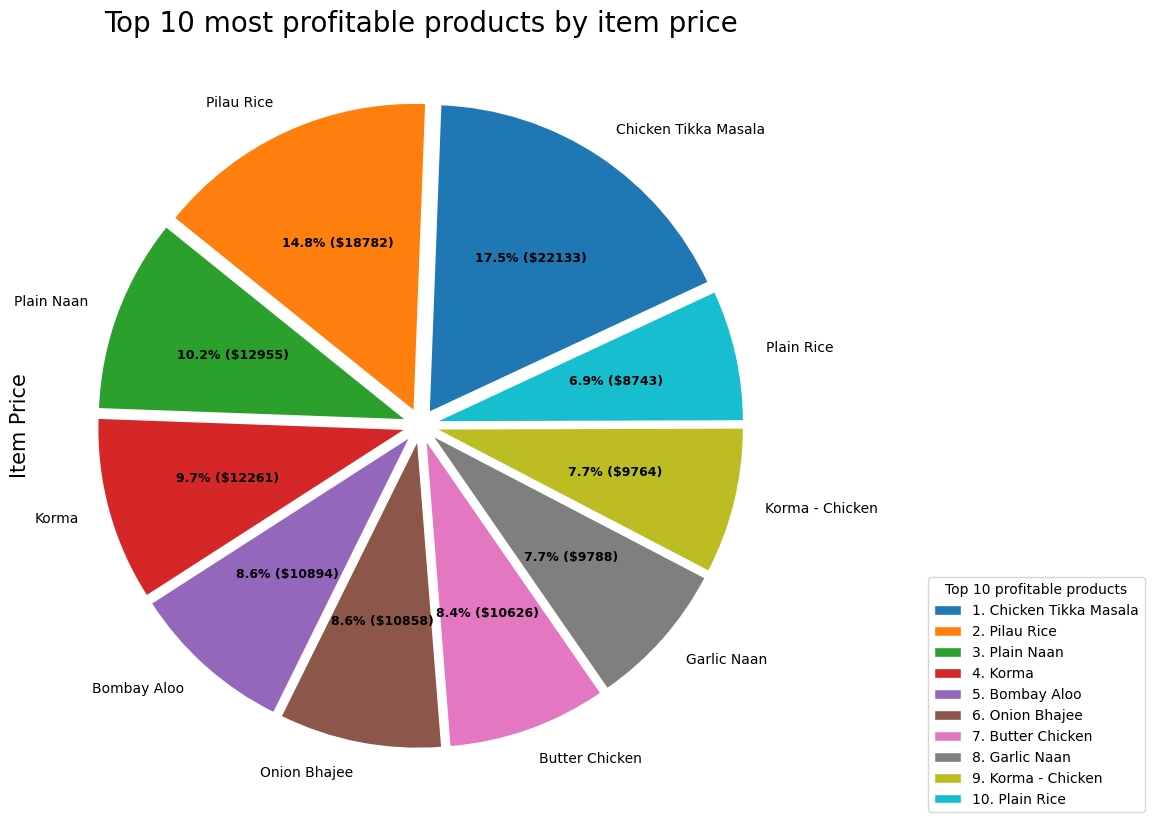

In [4]:
df["item_price"] = df["price"] * df["quantity"]

product_sales = df.groupby(["product_name"]).agg({"item_price": "sum"})
top_products = product_sales.sort_values("item_price", ascending=False).head(10)
top_products["percentage"] = top_products["item_price"] / top_products["item_price"].sum() * 100

explode = [0.05] * 10
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    top_products["item_price"],
    labels=top_products.index,
    autopct=lambda pct: f"{pct:.1f}% (${int(pct/100*top_products['item_price'].sum())})",
    startangle=25,
    explode=explode,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)

plt.setp(autotexts, size = 9, weight ="bold")
ax.set_title("Top 10 most profitable products by item price").set_size(20)
labels = [f"{idx+1}. {name}" for idx, name in enumerate(top_products.index)]
ax.legend(wedges, labels, title="Top 10 profitable products", loc="center left", bbox_to_anchor=(1.15, -0.1, 0.5, 0.5))
ax.set_ylabel("Item Price").set_size(15)
plt.show()


# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

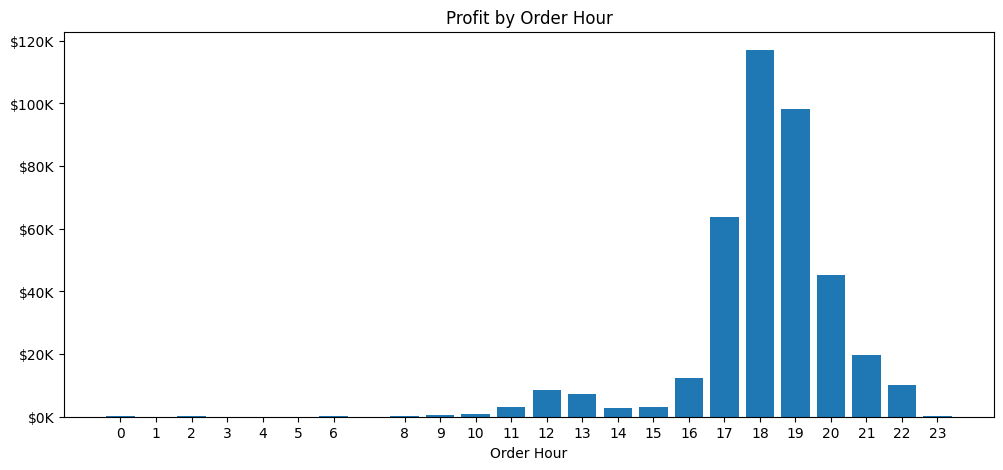

In [5]:
df["datetime"] = pd.to_datetime(df["datetime"])
hourly_sales = df.groupby(df["datetime"].dt.hour)["price"].sum()
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(hourly_sales.index, hourly_sales.values, width=0.8)
plt.xlabel("Order Hour")
plt.title("Profit by Order Hour")
plt.xticks(hourly_sales.index)
formatter = ticker.FuncFormatter(lambda x, pos: f"${x/1000:.0f}K")
ax.yaxis.set_major_formatter(formatter)
plt.show()


# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

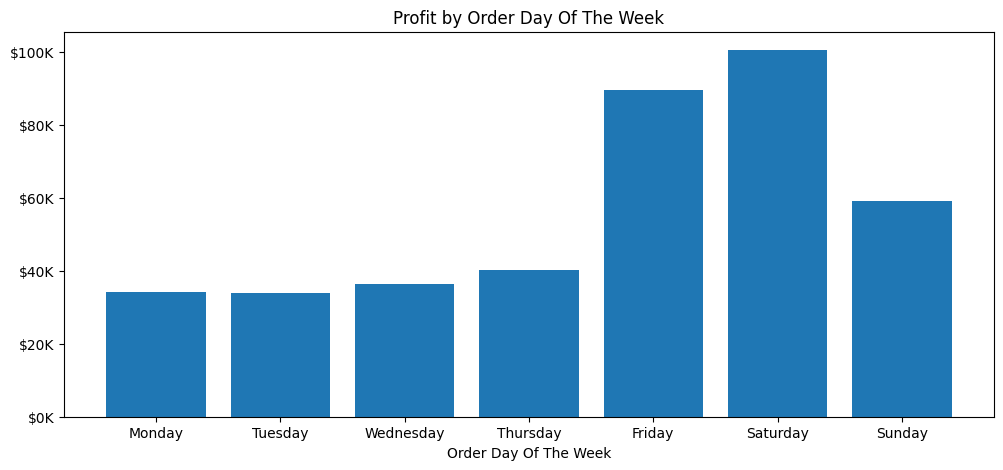

In [6]:
df["datetime"] = pd.to_datetime(df["datetime"])
daily_sales = df.groupby(df["datetime"].dt.dayofweek)["price"].sum()

fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(daily_sales.index, daily_sales.values, width=0.8)
plt.xlabel("Order Day Of The Week")
plt.title("Profit by Order Day Of The Week")
plt.xticks(daily_sales.index, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
formatter = ticker.FuncFormatter(lambda x, pos: f"${x/1000:.0f}K")
ax.yaxis.set_major_formatter(formatter)
plt.show()


# Personal
Get Top 10 most products combinations in restaurant sold by Quantity.




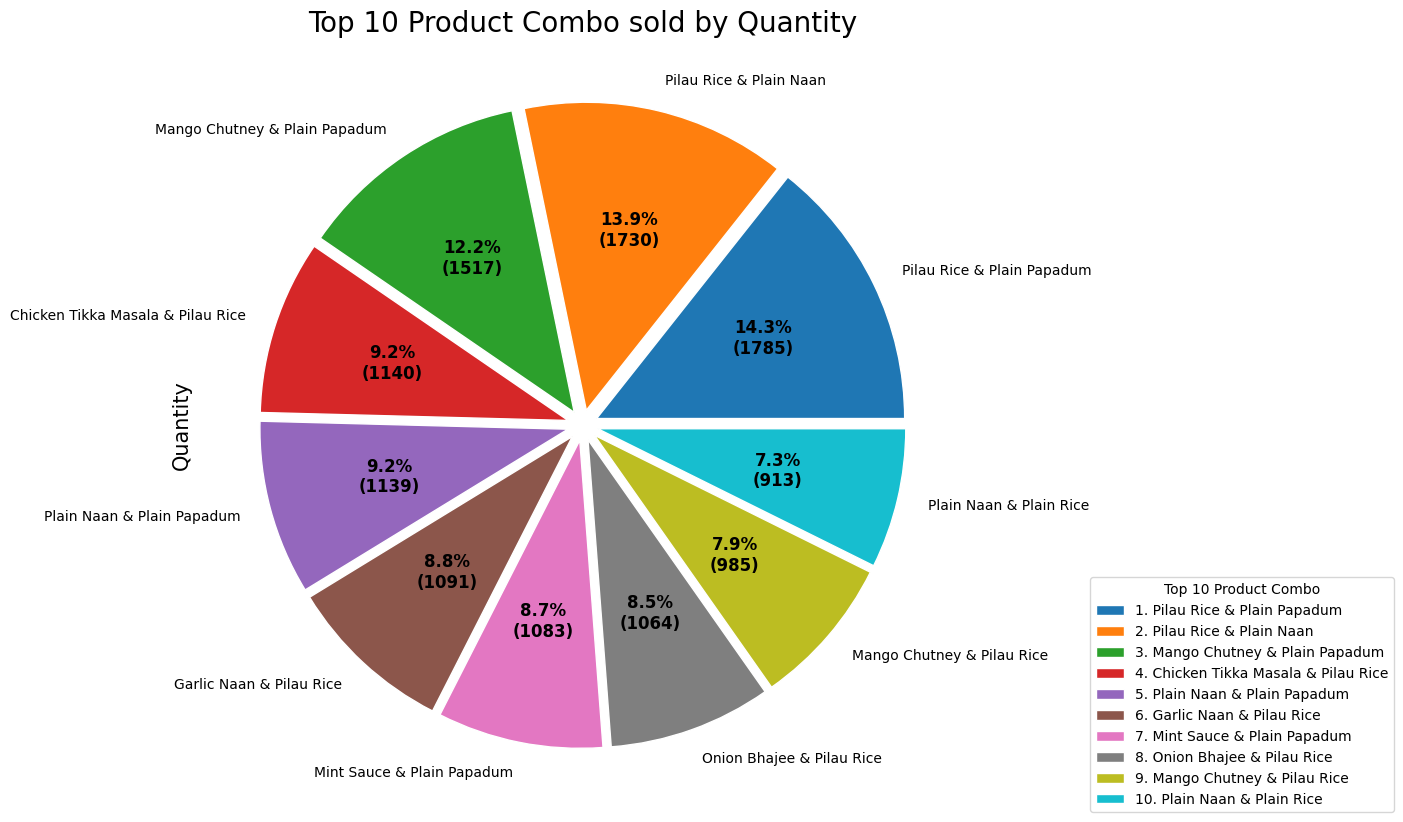

In [7]:
order_product_combo = df.groupby("order_id")["product_name"].apply(lambda x: list(combinations(x, 2)))
order_product_combo = [tuple(sorted(combo)) for combo_list in order_product_combo for combo in combo_list]

combination_counts = Counter(order_product_combo)

top_combinations = combination_counts.most_common(10)


def autopct_format(pct, total):
    absolute = int(round(pct * sum(total) / 100.0))
    return f"{pct:.1f}%\n({absolute:d})"


labels = [f"{combo[0][0]} & {combo[0][1]}" for combo in top_combinations]
quantities = [combo[1] for combo in top_combinations]
explode = [0.05] * 10

fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    quantities,
    labels=labels,
    autopct=lambda pct: autopct_format(pct, quantities),
    explode=explode,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)
plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Top 10 Product Combo sold by Quantity").set_size(20)
labels = [f"{idx+1}. {name}" for idx, name in enumerate(labels)]
ax.legend(
    wedges,
    labels,
    title="Top 10 Product Combo",
    loc="center left",
    bbox_to_anchor=(1.15, -0.1, 0.5, 0.5)
)
ax.set_ylabel("Quantity").set_size(15)
plt.show()
